In [242]:
# !pip3 install scikit-learn

In [243]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
#import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

#import keras
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras import backend as K
import itertools
#from keras.layers import BatchNormalization
#from tf.keras.utils import to_categorical # convert to one-hot-encoding
#from tensorflow.keras import layers, models
#import tensorflow as tf

#from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [244]:
base_skin_dir = 'archive/'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [245]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [246]:
# skrink dataset
print(f"Original Size: {skin_df.shape}")
skin_df = skin_df.sample(frac=0.1) # shuffle the dataset
print(f"Shrunk Size: {skin_df.shape}")

Original Size: (10015, 10)
Shrunk Size: (1002, 10)


In [247]:
#skin_df.isnull().sum()

In [248]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [249]:
#skin_df.isnull().sum()

In [250]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [251]:
#fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
#skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [252]:
#skin_df['dx_type'].value_counts().plot(kind='bar')

In [253]:
#skin_df['localization'].value_counts().plot(kind='bar')

In [254]:
#skin_df['age'].hist(bins=40)

In [255]:
#skin_df['sex'].value_counts().plot(kind='bar')

In [256]:
#print(skin_df.head)

In [257]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [258]:
'''n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')'''
        
#fig.savefig('category_samples.png', dpi=300)

"n_samples = 5\nfig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))\nfor n_axs, (type_name, type_rows) in zip(m_axs, \n                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):\n    n_axs[0].set_title(type_name)\n    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):\n        c_ax.imshow(c_row['image'])\n        c_ax.axis('off')"

In [259]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    1002
Name: image, dtype: int64

In [260]:
#print(skin_df.head)

In [261]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [262]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [263]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [264]:
#print(y_test_o)

In [265]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [266]:
#print(y_test)

In [267]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [268]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [269]:
input_shape = (75, 100, 3)
num_classes = 7

# Dropout

The larger the dropout the greater the uncertainty will be. This is because the model is less confident in the predictions it makes.

In [270]:
from tensorflow.keras import models, layers

def create_model(input_shape, num_classes, dropout_rate=0.1):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(dropout_rate), 

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(dropout_rate),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),  # Dropout layer for uncertainty
        layers.Dense(num_classes, activation='softmax')  # Output layer (e.g., 10 classes for MNIST)
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage:
input_shape = (75, 100, 3)  # Replace with your actual input shape
num_classes = 7  # Replace with the number of classes for your dataset

# Create the model
model = create_model(input_shape=input_shape, num_classes=num_classes)

# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

In [271]:
# Define the optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [272]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [273]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [274]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

import matplotlib.pyplot as plt

# Select an image from the test set
img = x_train[0]  # Select the first image in the test set (without the extra dimension)
print(img.shape)

# Plot the image using matplotlib
plt.imshow(img.astype('uint8'))
plt.title('Test Image')
plt.axis('off')  # Turn off the axis for a cleaner image display
plt.show()

import matplotlib.pyplot as plt

# Assuming you normalized the images earlier (x_test - mean) / std
# You need to reverse this by multiplying by the standard deviation and adding the mean back

# Rescale the image
img_rescaled = (x_test[0] * x_test_std) + x_test_mean  # Undo normalization

# Ensure the pixel values are in the range [0, 255] for proper visualization
img_rescaled = np.clip(img_rescaled, 0, 255).astype('uint8')

# Plot the image using matplotlib
plt.imshow(img_rescaled)
plt.title('Rescaled Test Image')
plt.axis('off')  # Turn off the axis for a cleaner image display
plt.show()

In [275]:
# Fit the model
EPOCHS = 10
batch_size = 128

history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = EPOCHS, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
5/5 [==============================] - 1s 193ms/step - loss: 1.3371 - accuracy: 0.5676 - val_loss: 1.1636 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - 1s 172ms/step - loss: 1.0716 - accuracy: 0.6723 - val_loss: 1.0926 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 3/10
5/5 [==============================] - 1s 169ms/step - loss: 0.9450 - accuracy: 0.7111 - val_loss: 1.0611 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.9681 - accuracy: 0.6824
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 [==============================] - 1s 169ms/step - loss: 0.9681 - accuracy: 0.6824 - val_loss: 1.0298 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 5/10
5/5 [==============================] - 1s 173ms/step - loss: 0.9714 - accuracy: 0.6824 - val_loss: 1.0021 - val_accuracy: 0.7160 - lr: 5.0000e-04
Epoch 6/10
5/5 [==============================] - 1s 186ms/step - loss: 0.

In [276]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)

print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

3/3 [==============================] - 0s 12ms/step - loss: 0.9967 - accuracy: 0.7037
Validation: accuracy = 0.703704  ;  loss_v = 0.996691
Test: accuracy = 0.646766  ;  loss = 1.028762


In [277]:
#model.save(f"model_dropout_test_acc_{accuracy:.2f}.keras")
model.save("model_new_3.keras")

In [278]:
# multiple forward passes
# calculate the variance between all the outputs
def monte_carlo_dropout(model, x_input, n_iter=100):
    # store predictions from multiple forward passes
    predictions = np.array([model(x_input, training=True) for _ in range(n_iter)])

    # mean of predictions
    mean_prediction = np.mean(predictions, axis=0)

    # variance of the predictions (uncertainty)
    variance_prediction = np.var(predictions, axis=0)

    return mean_prediction, variance_prediction

In [279]:
# sample
sample_index = slice(22,23)
x_sample = x_test[sample_index]

import matplotlib.pyplot as plt

# Select a sample image and its true label from the test set
#sample_index = 1  # You can change this to view different images
#x_sample = x_test[sample_index]
y_sample_true = np.argmax(y_test[sample_index])  # True label (in numeric form)

'''# Visualize the image
plt.imshow(x_sample.reshape(75, 100), cmap='gray')  # Reshape the image and display it
plt.title(f"True Label: {y_sample_true}")  # Add the true label as the title
plt.axis('off')  # Turn off axis for clarity
plt.show()'''

'# Visualize the image\nplt.imshow(x_sample.reshape(75, 100), cmap=\'gray\')  # Reshape the image and display it\nplt.title(f"True Label: {y_sample_true}")  # Add the true label as the title\nplt.axis(\'off\')  # Turn off axis for clarity\nplt.show()'

In [280]:
# get mean and uncertainty (variance) using Monte Carlo Dropout
mean_prediction, uncertainty = monte_carlo_dropout(model, x_sample, n_iter=100)

# results
print(f"Mean Prediction: {mean_prediction}")
print(f"Uncertainty (Variance): {uncertainty}")

Mean Prediction: [[0.12874912 0.1260105  0.14950816 0.04497997 0.43402562 0.07358332
  0.04314333]]
Uncertainty (Variance): [[1.7056659e-04 1.8354213e-04 2.0423338e-04 4.6410998e-05 9.1201119e-04
  1.1263155e-04 6.4438733e-05]]


In [281]:
# GETTING SINGULAR UNCERTAINTY VALUE

# MEAN UNCERTAINTY (VARIANCE)
# overall average uncertainty across ALL classes
# stupid
# mean_uncertainty = np.mean(uncertainty)
# print(f"Mean Uncertainty: {mean_uncertainty}")

# VARIANCE OF PREDICTED CLASS
# we only care about uncertainty related to predicted class (class with highest mean probability)
print(f"Model Predictions (mean prediction): {mean_prediction}")
print(f"Model Uncertainty (variance): {uncertainty}")
predicted_class = np.argmax(mean_prediction)
print(f"Predicted Class: {predicted_class}")
class_uncertainty = uncertainty[0, predicted_class]
# convert to percent
class_uncertainty = class_uncertainty * 100
print(f"Uncertainty for predicted class {predicted_class}: {class_uncertainty:.2f}%")

Model Predictions (mean prediction): [[0.12874912 0.1260105  0.14950816 0.04497997 0.43402562 0.07358332
  0.04314333]]
Model Uncertainty (variance): [[1.7056659e-04 1.8354213e-04 2.0423338e-04 4.6410998e-05 9.1201119e-04
  1.1263155e-04 6.4438733e-05]]
Predicted Class: 4
Uncertainty for predicted class 4: 0.09%


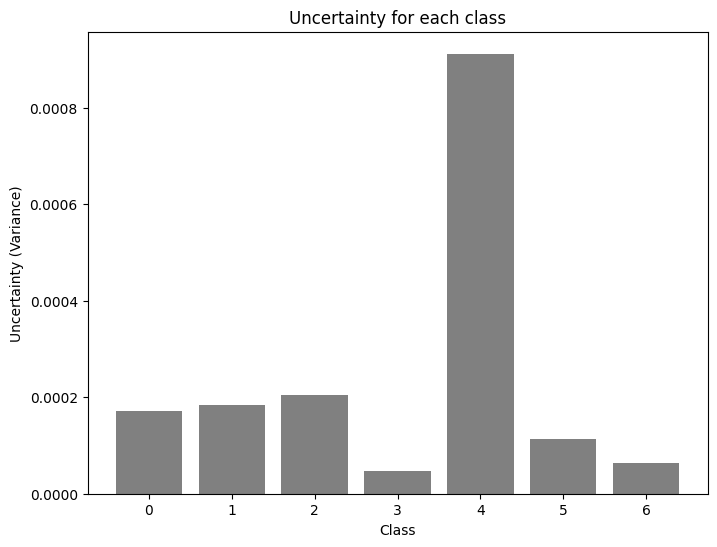

In [282]:
import matplotlib.pyplot as plt

def plot_uncertainty(uncertainty, mean_prediction):
    plt.figure(figsize=(8, 6))
    plt.bar(range(7), uncertainty[0], color='gray')
    plt.xticks(range(7), range(7))
    plt.title(f"Uncertainty for each class")
    plt.xlabel("Class")
    plt.ylabel("Uncertainty (Variance)")
    plt.show()

plot_uncertainty(uncertainty, mean_prediction)

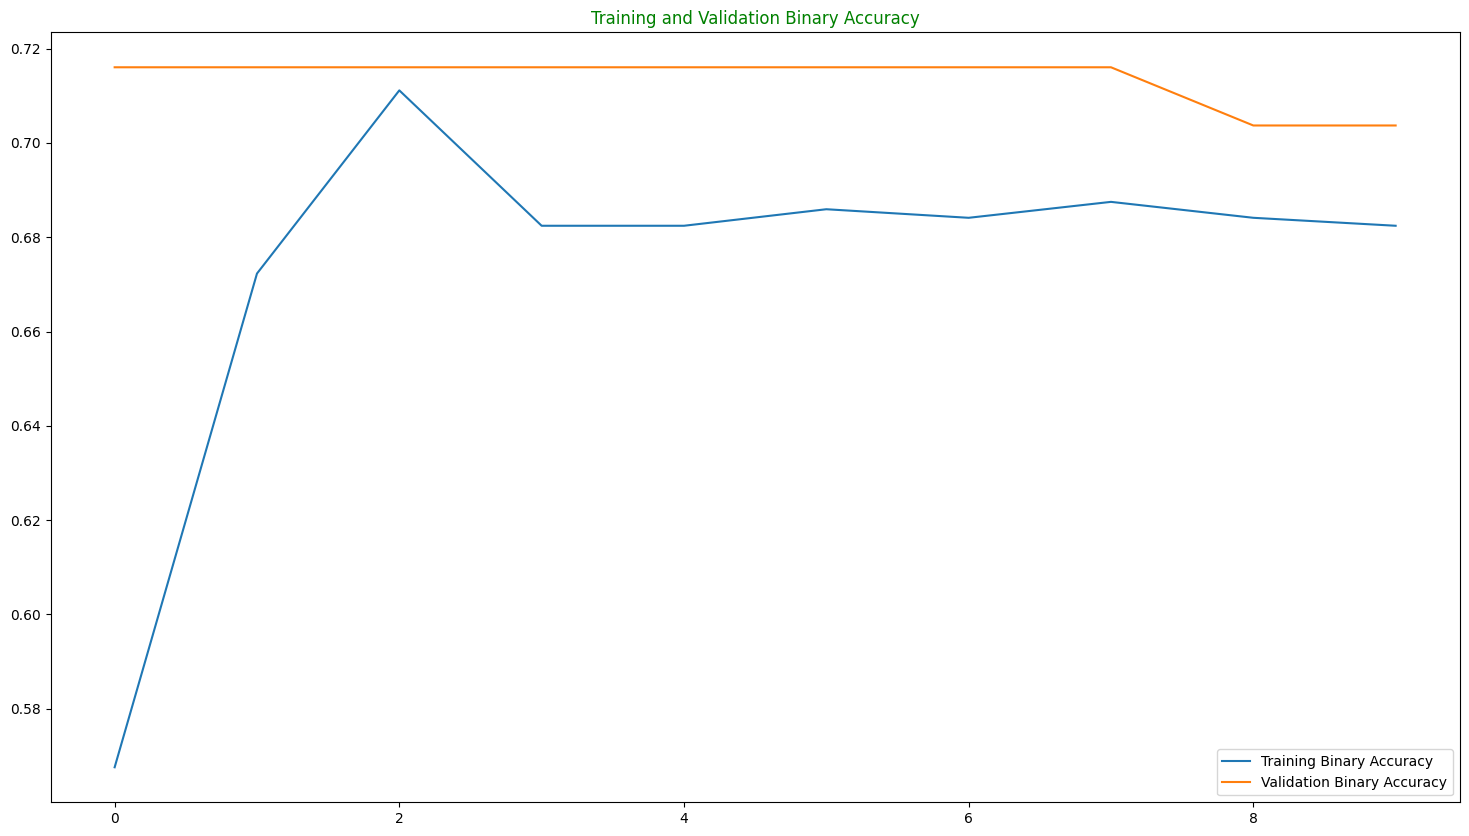

In [283]:
# Graph of Binary Accuracy 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(40, 10))
plt.subplot(1, 2, 1)
#plt.grid()
plt.plot(epochs_range, acc, label='Training Binary Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Binary Accuracy', color='Green')
plt.savefig('TrainingValidationAccuracy.png')

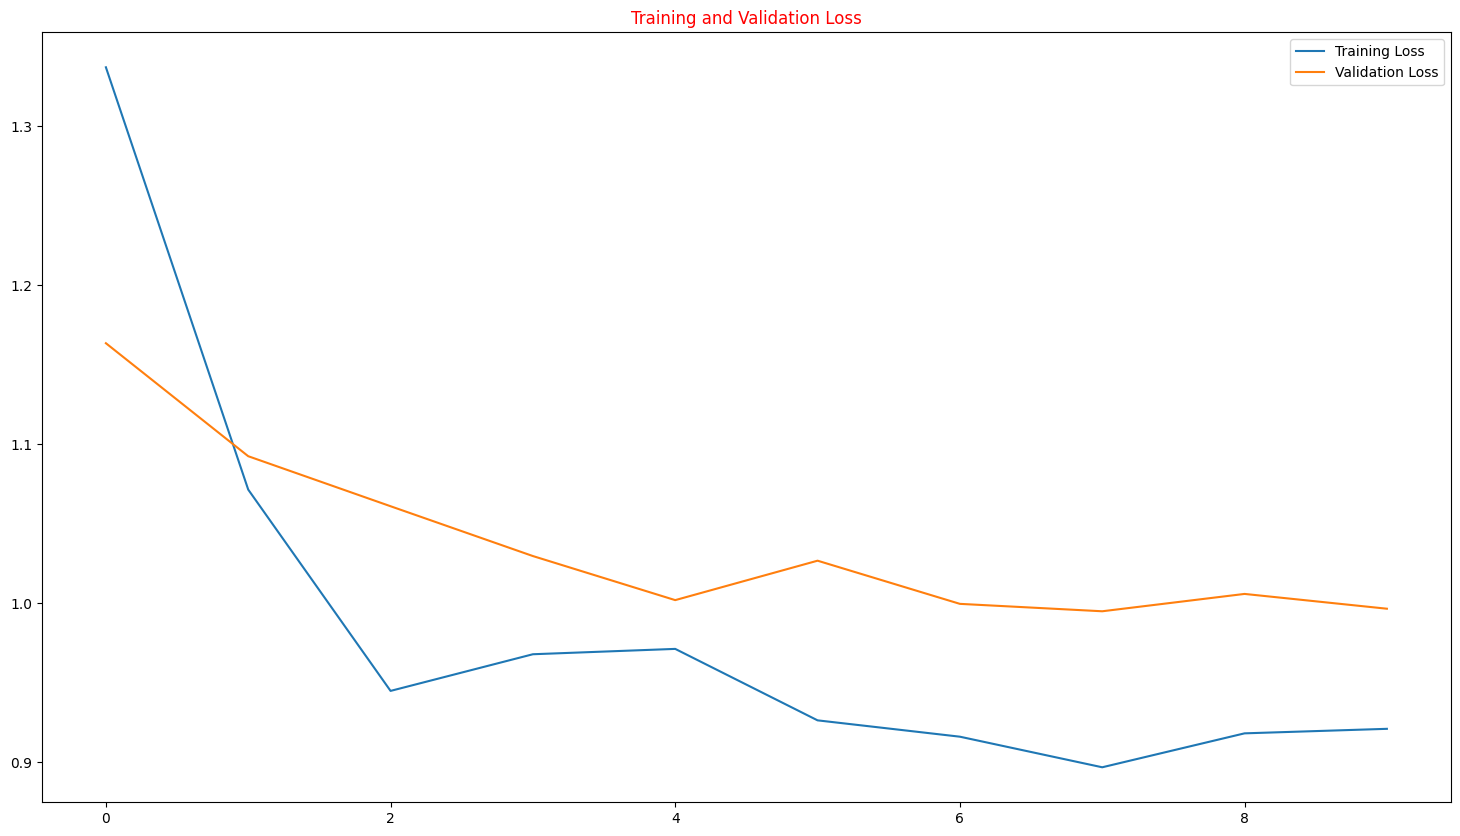

<Figure size 640x480 with 0 Axes>

In [284]:
# Graph of Loss
plt.figure(figsize=(40, 10))
plt.subplot(1, 2, 2)
#plt.grid()
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', color='red')
plt.show()
plt.savefig('TrainingValidationLoss.png')

3/3 [==============================] - 0s 12ms/step


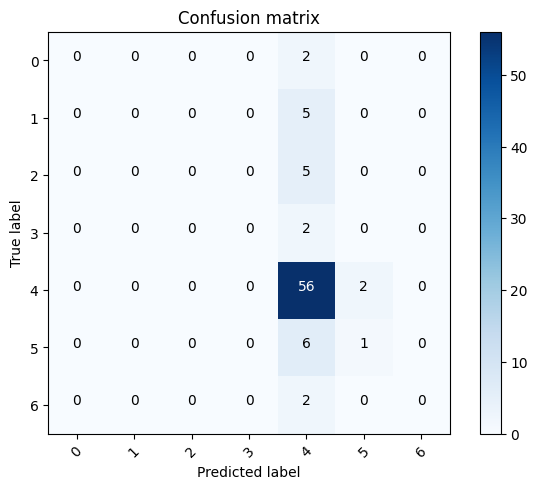

In [285]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

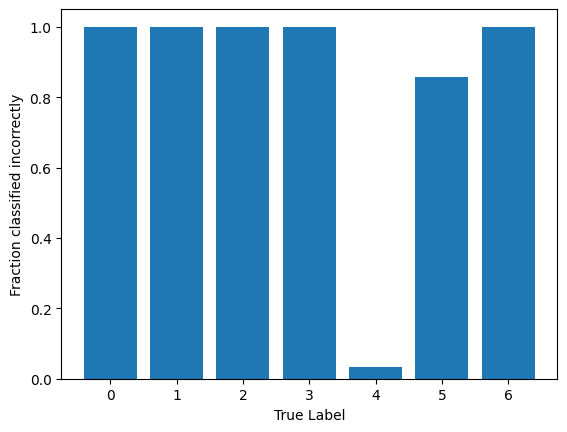

In [286]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')